In [4]:
import pandas as pd 

# thư viên bắt buộc 
from pandas_datareader.data import DataReader

import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer

# vẽ biểu đồ cho ngầu 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# xử lý thời gian 
from datetime import datetime

# keras for LSTM
# phải cài cái này 
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

In [5]:
# Read the CSV file and set 'Date' as the index
df = pd.read_csv('AAPL.csv')
df.set_index('Date', inplace=True)

# Convert the 'Date' index to datetime format
df.index = pd.to_datetime(df.index, dayfirst=True)

# Filter the DataFrame 
start_date = '2005/05/27'
end_date = '2024/05/24'
mask = (df.index >= start_date) & (df.index <= end_date)
df_filtered = df.loc[mask]
df_filtered


C:\Users\DELL\AppData\Local\Temp\ipykernel_4364\389102602.py:6: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df.index = pd.to_datetime(df.index, dayfirst=True)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2005-05-27,1.451429,1.456786,1.428929,1.448571,1.224698,316008000
2005-05-31,1.452143,1.455000,1.413571,1.420000,1.200543,404205200
2005-06-01,1.424643,1.455714,1.423571,1.439286,1.216848,453812800
2005-06-02,1.430357,1.440000,1.414286,1.430000,1.208997,373973600
2005-06-03,1.362857,1.377857,1.348929,1.365714,1.154647,956869200
...,...,...,...,...,...,...
2024-05-20,189.330002,191.919998,189.009995,191.039993,191.039993,44361300
2024-05-21,191.089996,192.729996,190.919998,192.350006,192.350006,42309400
2024-05-22,192.270004,192.820007,190.270004,190.899994,190.899994,34648500


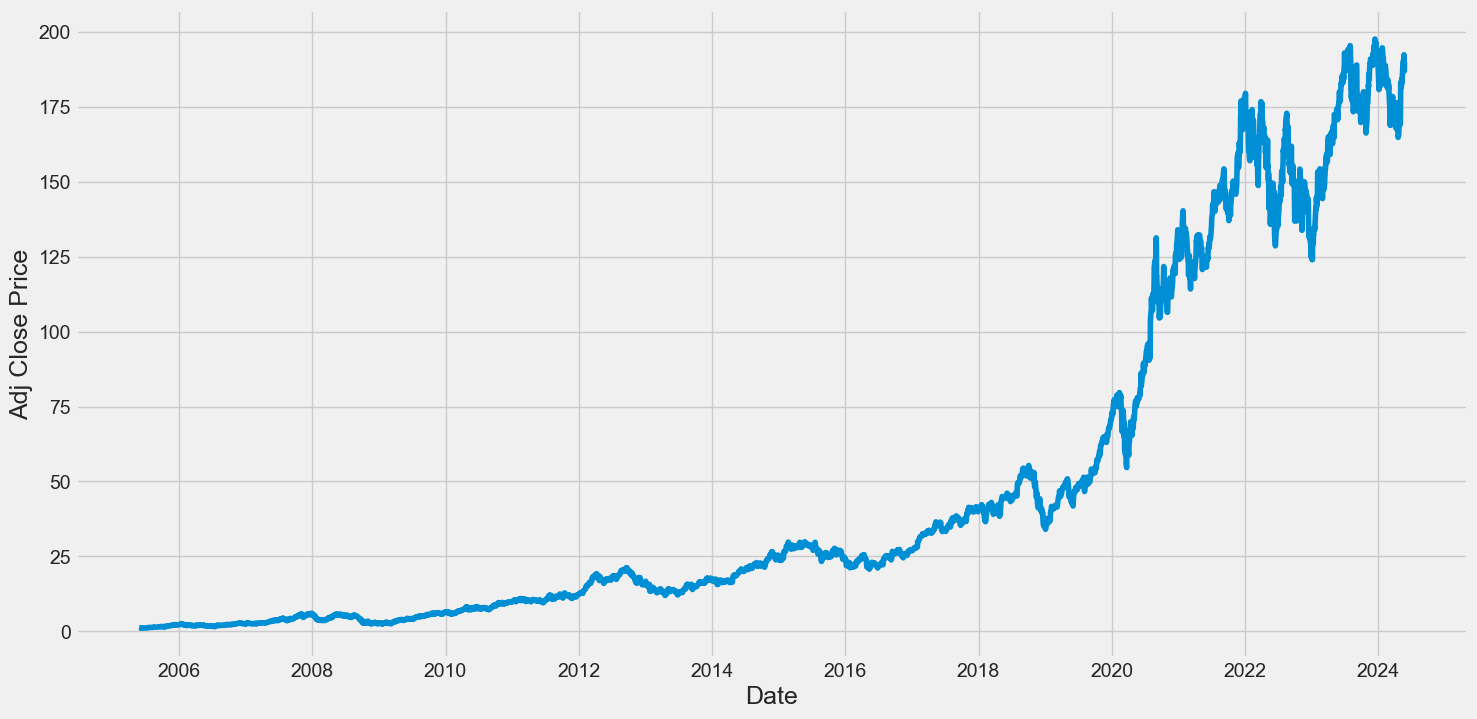

In [6]:
plt.figure(figsize=(16,8))
plt.plot(df['Adj Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Adj Close Price', fontsize=18)
plt.show()

In [7]:
# Chia tập dữ liệu để làm việc
def splitDataset(df):
    length = df.shape[0]
    sixtyPercent = length * 60 // 100
    eightyPercent = length * 80 // 100
    train_df = df[:sixtyPercent]
    val_df = df[sixtyPercent:eightyPercent]
    test_df = df[eightyPercent:]
    return train_df, val_df, test_df

train_df, val_df, test_df = splitDataset(df)

train_df.shape, val_df.shape, test_df.shape

((2868, 6), (956, 6), (957, 6))

In [8]:
# Tiền xử lý tập train và tạo preprocess_pipeline
# tạo dataframe chỉ bao gồm cột index và cột Adj Close Price 
def createDataFrame(df):
    return df.filter(['Adj Close'])

real_train_df = createDataFrame(train_df)
real_train_df.shape

(2868, 1)

In [9]:
# scale dữ liệu train
scaler = MinMaxScaler()
scaled_train_data = scaler.fit_transform(real_train_df)

def reshapeForModel(scaled_train_data):
    return scaled_train_data.reshape((-1,))

scaled_train_data = reshapeForModel(scaled_train_data)
scaled_train_data.shape

(2868,)

In [10]:
# tạo dữ liệu train_X và train_y
def createTrainX_y(scaled_train_data, time_steps=60, out_length=1):
    train_X = []
    train_y = []
    for i in range(len(scaled_train_data) - time_steps - out_length + 1):
        end_X = i + time_steps
        end_y = end_X + out_length
        train_X.append(scaled_train_data[i:end_X])
        train_y.append(scaled_train_data[end_X:end_y])

    train_X, train_y = np.array(train_X), np.array(train_y)
    return train_X.reshape((train_X.shape[0], train_X.shape[1], 1)), train_y

train_X, train_y = createTrainX_y(scaled_train_data)
train_X.shape, train_y.shape

((2808, 60, 1), (2808, 1))

In [11]:
preprocess_pipeline = Pipeline([
    ('dropper', FunctionTransformer(createDataFrame)),
    ('scaler', MinMaxScaler()),
    ('reshape', FunctionTransformer(reshapeForModel)),
    ('createTrain', FunctionTransformer(createTrainX_y)),
])

train_X, train_y = preprocess_pipeline.fit_transform(train_df)
train_X.shape, train_y.shape

((2808, 60, 1), (2808, 1))

In [12]:
# Tạo model 
def createModel(train_X, time_steps=60, out_length=1):
    model = Sequential()
    model.add(LSTM(60, activation='tanh', return_sequences=False, input_shape=(train_X.shape[1], 1)))
    model.add(Dense(out_length))
    model.compile(optimizer='adam', loss='mse')

    return model

In [13]:
# xử lý tập validation
# tạo tập inputs
val_inputs = df[len(df) - len(val_df) - 60:]
val_X, val_y = preprocess_pipeline.transform(val_inputs)
val_X.shape, val_y.shape

((956, 60, 1), (956, 1))

In [14]:
# thử nhiều tham số epochs để tìm ra model tốt nhất
epochs_ = [1,2,3,4,5,6]
best_val_err = float('inf')
best_epoch = None

for e in epochs_:
    # build model 
    model = createModel(train_X)
    model.fit(train_X, train_y, batch_size=1, epochs=e)

    # dự đoán tập inputs
    pred_val = model.predict(val_X)
    pred_val = preprocess_pipeline.inverse_transform(pred_val)

    val_df['Predict'] = pred_val
    mse = np.sqrt(np.mean(((val_df['Predict'] - val_df['Adj Close']) ** 2)))
    if mse < best_val_err:
        best_val_err = mse 
        best_epoch = e
        print(e, mse)

30/30 [==============================] - 1s 10ms/step
1 57.4872991184026


C:\Users\DELL\AppData\Local\Temp\ipykernel_4364\304041015.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['Predict'] = pred_val


Epoch 1/2
2808/2808 [==============================] - 41s 14ms/step - loss: 9.8599e-04
Epoch 2/2
30/30 [==============================] - 1s 14ms/step


C:\Users\DELL\AppData\Local\Temp\ipykernel_4364\304041015.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['Predict'] = pred_val


Epoch 1/3
2808/2808 [==============================] - 44s 15ms/step - loss: 0.0011
Epoch 2/3
2808/2808 [==============================] - 43s 15ms/step - loss: 2.8017e-04
Epoch 3/3
30/30 [==============================] - 1s 14ms/step


C:\Users\DELL\AppData\Local\Temp\ipykernel_4364\304041015.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['Predict'] = pred_val


Epoch 1/4
2808/2808 [==============================] - 45s 15ms/step - loss: 0.0017
Epoch 2/4
2808/2808 [==============================] - 40s 14ms/step - loss: 3.4731e-04
Epoch 3/4
2808/2808 [==============================] - 39s 14ms/step - loss: 2.4832e-04
Epoch 4/4
30/30 [==============================] - 6s 15ms/step


C:\Users\DELL\AppData\Local\Temp\ipykernel_4364\304041015.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['Predict'] = pred_val


Epoch 1/5
2808/2808 [==============================] - 144s 37ms/step - loss: 0.0011
Epoch 2/5
2808/2808 [==============================] - 100s 36ms/step - loss: 2.7429e-04
Epoch 3/5
2808/2808 [==============================] - 101s 36ms/step - loss: 2.0799e-04
Epoch 4/5
2808/2808 [==============================] - 128s 45ms/step - loss: 1.6118e-04
Epoch 5/5
30/30 [==============================] - 7s 31ms/step


C:\Users\DELL\AppData\Local\Temp\ipykernel_4364\304041015.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['Predict'] = pred_val


Epoch 1/6
2808/2808 [==============================] - 122s 36ms/step - loss: 0.0011
Epoch 2/6
2808/2808 [==============================] - 101s 36ms/step - loss: 3.1454e-04
Epoch 3/6
2808/2808 [==============================] - 101s 36ms/step - loss: 2.4000e-04
Epoch 4/6
2808/2808 [==============================] - 102s 36ms/step - loss: 1.8612e-04
Epoch 5/6
2808/2808 [==============================] - 101s 36ms/step - loss: 1.5798e-04
Epoch 6/6
30/30 [==============================] - 8s 32ms/step


C:\Users\DELL\AppData\Local\Temp\ipykernel_4364\304041015.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['Predict'] = pred_val


In [15]:
# fit model với tập train và predict tập test
# tạo dữ liệu train để fit (bao gồm train_df và valid_df)
train_inputs = df[:len(df) - len(test_df) - 60]
train_X, train_y = preprocess_pipeline.fit_transform(train_inputs)

# build model 
model = createModel(train_X)
model.fit(train_X, train_y, batch_size=1, epochs=best_epoch)

3704/3704 [==============================] - 162s 35ms/step - loss: 4.8842e-04


In [16]:
# tạo dữ liệu test 
test_inputs = df[len(df) - len(test_df) - 60:]
test_X, test_y = preprocess_pipeline.transform(test_inputs)

# dự đoán tập inputs và chuẩn hóa ngược lại về dạng giá ban đầu 
pred_test = model.predict(test_X)
pred_test = preprocess_pipeline.inverse_transform(pred_test)

30/30 [==============================] - 6s 24ms/step


In [17]:
# dự đoán tập inputs và chuẩn hóa ngược lại về dạng giá ban đầu 
pred_test = model.predict(test_X)
pred_test = preprocess_pipeline.inverse_transform(pred_test)
pred_test.shape

30/30 [==============================] - 1s 30ms/step


(957, 1)

C:\Users\DELL\AppData\Local\Temp\ipykernel_4364\1515979675.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = pred_test


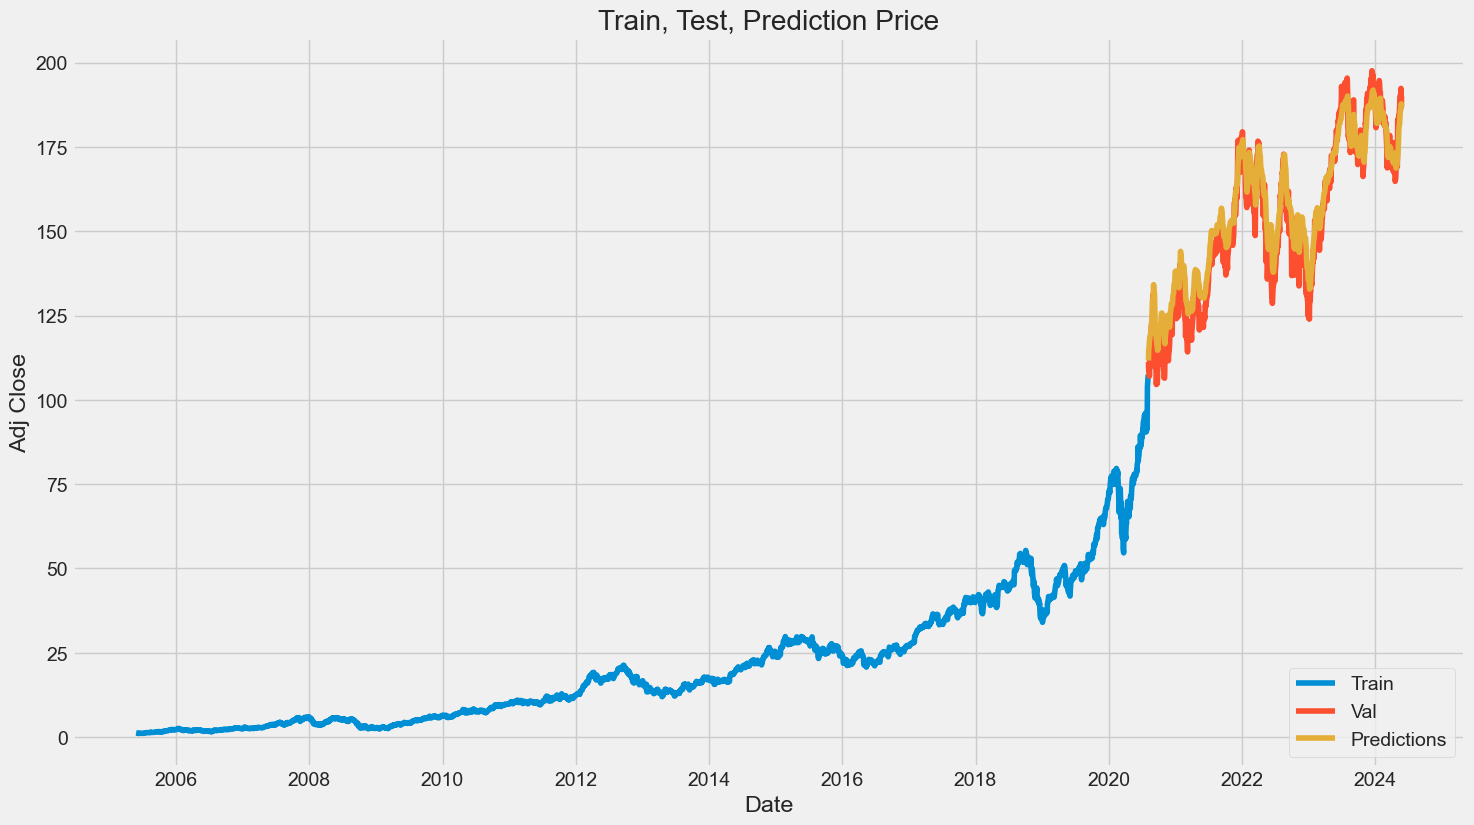

In [18]:
# vẽ đồ thị phần train, test và predict 
length = df.shape[0]
eightyPercent = length * 80 // 100
train = df[:eightyPercent]
test = df[eightyPercent:]
test['Predictions'] = pred_test

plt.figure(figsize=(16,9))
plt.title('Train, Test, Prediction Price')
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.plot(train['Adj Close'])
plt.plot(test[['Adj Close','Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [19]:
test

,Open,High,Low,Close,Adj Close,Volume,Predictions
Date,,,,,,,
2020-08-06,110.404999,114.412498,109.797501,113.902496,111.238914,202428800,111.656311
2020-08-07,113.205002,113.675003,110.292503,111.112503,108.709808,198045600,114.510628
2020-08-10,112.599998,113.775002,110.000000,112.727501,110.289871,212403600,116.215034
2020-08-11,111.970001,112.482498,109.107498,109.375000,107.009872,187902400,117.593559
2020-08-12,110.497498,113.275002,110.297501,113.010002,110.566261,165598000,117.760742
...,...,...,...,...,...,...,...
2024-05-20,189.330002,191.919998,189.009995,191.039993,191.039993,44361300,186.121719
2024-05-21,191.089996,192.729996,190.919998,192.350006,192.350006,42309400,186.792419
2024-05-22,192.270004,192.820007,190.270004,190.899994,190.899994,34648500,187.498672


In [20]:
mse = np.sqrt(np.mean((test['Adj Close'] - test['Predictions']) ** 2))
print(mse)

5.94491158266953
